# Notebook to render novel views from trained models

Currently two ways to determine render_pose:
1. For the Human and the Johannes Scene it is convenient to generate novel view with time, azimuth, elevation in spherical coordinates
2. In the Bottle and Gobblet scene we have problems with the camera poses so that spherical coordinates don't give expected novel views
--> we created a function which interpolates between two poses out of the Raw Datafiles (!: EXR_RGBD...and not human/johannes/...) with the specified number of interpolation steps 

In [1]:
#%env CUDA_VISIBLE_DEVICES ""      # Rendering on CPU is approx. 10x slower
%env CUDA_VISIBLE_DEVICES 2

from run_dnerf import config_parser, create_nerf
import matplotlib.pyplot as plt
import torch
from utils.load_blender import pose_spherical, pose_spherical2
from utils.load_owndataset import interpolate_between_two_poses
import run_dnerf
from run_dnerf import render_path, device, render
from run_dnerf_helpers import to8b, to8d
from utils import Arrow3D, draw_transformed, draw_cam, load_owndataset_data


%load_ext autoreload
%autoreload 2
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=2
[Import] Using CUDA version 10.2 on GeForce GTX 1080 Ti with global GPU index 2


In [2]:
scene_name = "gobblet"
scaling_factor = 0.744140625
rgb=False # if true plot rgb images, else depth images - only implemented in "by interpolating train images"

images, depth_maps, poses, times, render_poses, render_times, hwff, i_split = load_owndataset_data(f"./data/{scene_name}", True, 1, render_pose_type="spherical")
print(hwff)
print(times)
print(images.shape)

Scene Object Depth: 0.45
[Info] Data scaling factor: 0.744140625
[480, 360, 400.0368957519532, 400.0368957519531]
[0.         0.01086957 0.02173913 0.04347826 0.05434782 0.07608695
 0.09782609 0.10869565 0.11956522 0.13043478 0.14130434 0.1521739
 0.16304348 0.17391305 0.19565217 0.20652173 0.2173913  0.22826087
 0.23913044 0.25       0.26086956 0.2826087  0.29347825 0.3043478
 0.3152174  0.32608697 0.33695653 0.36956522 0.38043478 0.4021739
 0.41304347 0.42391303 0.4347826  0.4456522  0.4673913  0.47826087
 0.48913044 0.5        0.51086956 0.5217391  0.54347825 0.5543478
 0.5652174  0.57608694 0.5869565  0.59782606 0.6086956  0.6304348
 0.65217394 0.6630435  0.67391306 0.6847826  0.70652175 0.7173913
 0.7282609  0.73913044 0.76086956 0.7717391  0.79347825 0.8043478
 0.8152174  0.82608694 0.8369565  0.8695652  0.8804348  0.8913044
 0.90217394 0.9130435  0.92391306 0.9456522  0.95652175 0.9673913
 0.9782609  0.98913044 0.0326087  0.06521739 0.27173913 0.35869566
 0.6195652  0.75       0

In [3]:
# set cuda
torch.set_default_tensor_type('torch.cuda.FloatTensor')           # Use this when on GPU

# get config file
# config_file = "configs/johannes.txt"
config_file = "logs/gobblet_05_mse_dgs_hardcoded/config.txt"
parser = config_parser()
args = parser.parse_args(f'--config {config_file}')

# set render params
hwff = [480, 360, hwff[2], hwff[3]]
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 0.1, 'far' : 2.1})

[Config] NeRF type selected: direct_temporal
[Info] Found ckpts:
		./logs/gobblet_05_mse_dgs_hardcoded/300000.tar
		./logs/gobblet_05_mse_dgs_hardcoded/325000.tar
		./logs/gobblet_05_mse_dgs_hardcoded/350000.tar
		./logs/gobblet_05_mse_dgs_hardcoded/375000.tar
		./logs/gobblet_05_mse_dgs_hardcoded/400000.tar
[Config] Reloading from ./logs/gobblet_05_mse_dgs_hardcoded/400000.tar


## Generate Frame

### With spherical coordinates (good for Human and Johannes scene)

In [4]:
def generate_img(time, azimuth, elevation, depth):
    assert 0. <= time <= 1.
    assert -180 <= azimuth <= 180
    assert -180 <= elevation <= 180
    
    # render_poses = torch.unsqueeze(pose_spherical(azimuth, elevation, depth), 0).to(device)
    render_poses = torch.unsqueeze(pose_spherical2(azimuth, elevation, depth), 0).to(device)
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, disps, depths = render_path(render_poses, render_times, hwff, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    return rgbs[0], render_poses[0]

100%|██████████| 1/1 [00:05<00:00,  5.98s/it]


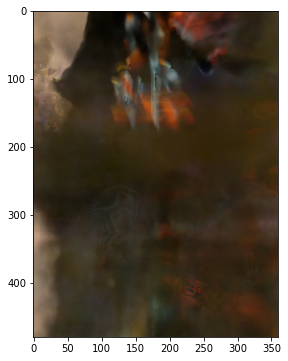

In [5]:
# HUMAN SCENE
# time = 0.55  # in [0,1]
# azimuth = -50  # in [-90,0]      
# elevation = -25  # in [-45,45]
# SCENE_OBJECT_DEPTH = 1.45

img, render_pose = generate_img(time, azimuth, elevation, depth=SCENE_OBJECT_DEPTH)

plt.figure(figsize=(20,6))
plt.imshow(img)
plt.show()

### By interpolating training poses (good for Bottle, Gobblet scene)

#### Ours

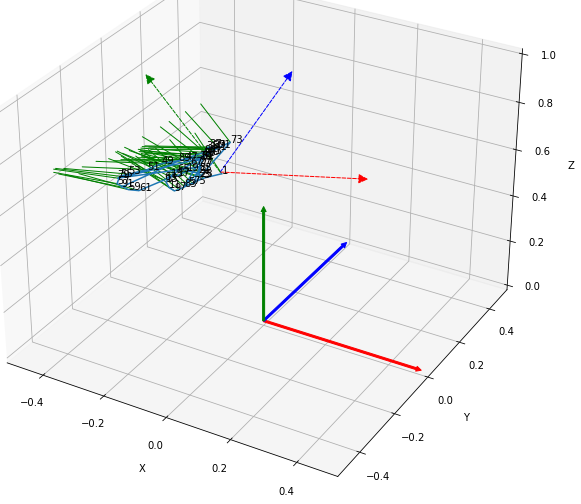

In [6]:
# Determine desired poses to be interpolated based on the generated graphic below
# Bottle scene: pose = pose_index_from_graphic * 5 (since we downsampled from 30fps to 6fps)
# Gobblet scene: pose = pose_index_from_graphic * 2 + 85 (since we start with frame 85 and downsampled from 30fps to 15fps)

pose1 = 75     # Bottle Scene: min 0 ; Gobblet scene: min 85
pose2 = 105    # Bottle Scene: max 457; Gobblet scene: max 270
render_pose = interpolate_between_two_poses(f"data/{scene_name}", pose1, pose2, 5, scaling_factor)[2]

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_xlim(-.5, .5)
ax1.set_ylim(-.5, .5)
ax1.set_zlim(0, 1)
arrow_prop_dict = dict(mutation_scale=10, arrowstyle='simple', shrinkA=0, shrinkB=0)
ax1.add_artist(Arrow3D([0, .5], [0, 0], [0, 0], **arrow_prop_dict, color='r'))
ax1.add_artist(Arrow3D([0, 0], [0, .5], [0, 0], **arrow_prop_dict, color='b'))
ax1.add_artist(Arrow3D([0, 0], [0, 0], [0, .5], **arrow_prop_dict, color='g'))

os = []
for i, pose in enumerate(poses):
    if i % 2 == 0:
        continue
    rcx, rcy, rcz, new_o = draw_transformed(pose, ax1, linestyle="-", only_z=True, axes_len=0.2, arrowstyle="-")
    os.append(new_o)
    ax1.text(*new_o, str(i))
ax1.plot([n[0] for n in os], [n[1] for n in os], [n[2] for n in os])

draw_transformed(render_pose, ax1, linestyle="--", axes_len=0.5)

ax1.dist = 7
plt.tight_layout()

plt.show();

#### Original Image to specified time

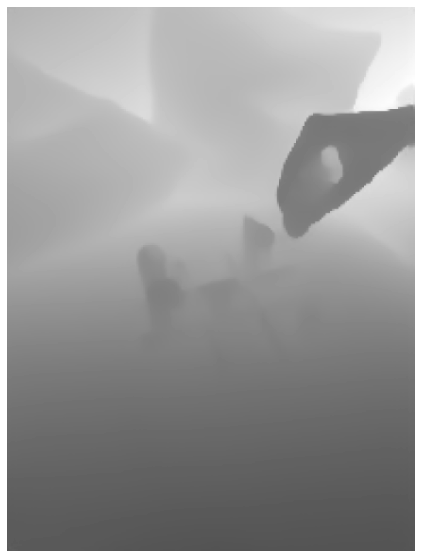

In [7]:
render_times = torch.Tensor([0.1521739]).to(device)

if rgb==True:
    img = to8b(images[11])
else:
    img = to8d(depth_maps[11])

plt.figure(figsize=(10,10))
if rgb==True:
    plt.imshow(img)
else:
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

plt.axis('off')
plt.show()

#### Ours

0


100%|██████████| 1/1 [00:11<00:00, 11.53s/it]


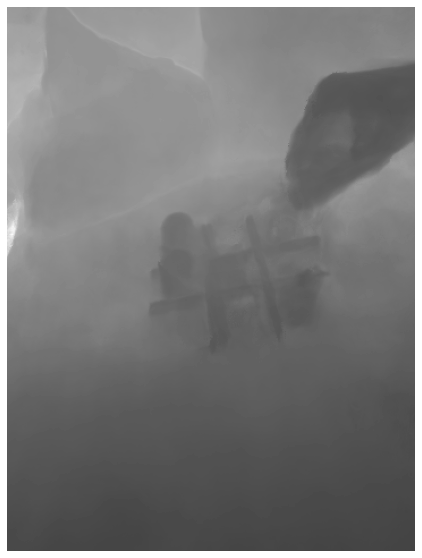

In [8]:
print(args.render_factor)
render_poses = torch.unsqueeze(torch.Tensor(render_pose), 0).to(device)
with torch.no_grad():
        rgbs, disps, depths = render_path(render_poses, render_times, hwff, args.chunk, render_kwargs_test, render_factor=args.render_factor)
if rgb==True:
    img = to8b(rgbs)[0]
else:
    img = to8d(depths)[0]

plt.figure(figsize=(10,10))
if rgb==True:
    plt.imshow(img)
else:
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

plt.axis('off')    
plt.show()

### D-NeRF

In [9]:
# get config file
# config_file = "configs/johannes.txt"
config_file = "logs/gobblet_06_dnerf/config.txt"
parser = config_parser()
args = parser.parse_args(f'--config {config_file}')

# set render params
hwff = [480, 360, hwff[2], hwff[3]]
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 0.1, 'far' : 2.1})

[Config] NeRF type selected: direct_temporal
[Info] Found ckpts:
		./logs/gobblet_06_dnerf/275000.tar
		./logs/gobblet_06_dnerf/300000.tar
		./logs/gobblet_06_dnerf/350000.tar
		./logs/gobblet_06_dnerf/400000.tar
[Config] Reloading from ./logs/gobblet_06_dnerf/400000.tar


100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


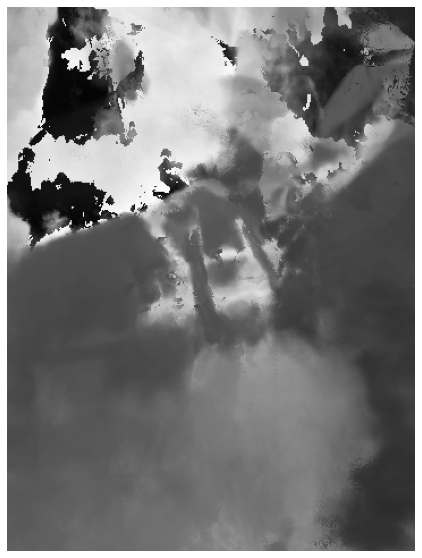

In [10]:
with torch.no_grad():
        rgbs, disps, depths = render_path(render_poses, render_times, hwff, args.chunk, render_kwargs_test, render_factor=args.render_factor)

if rgb==True:
    img = to8b(rgbs)[0]
else:
    img = to8d(depths)[0]
plt.figure(figsize=(10,10))
if rgb==True:
    plt.imshow(img)
else:
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

plt.axis('off')    
plt.show()